In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time

DATA_DIRECTORY = 'content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images'

In [ ]:
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets, BATCH_SIZE):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.vgg16(pretrained=False)
    for param in model.parameters():
        param.requires_grad = True  # Set requires_grad to True for fine-tuning
    num_output_classes = len(image_datasets['train'].classes)
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_output_classes)  # Adding a new layer for classification
    )
    return model.to(device)

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        if val_acc_history[-1] > best_acc:
            best_acc = val_acc_history[-1]

    print('Best validation Acc: {:4f}'.format(best_acc))

    plt.plot(range(len(train_acc_history)), train_acc_history, label='Training Accuracy')
    plt.plot(range(len(val_acc_history)), val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

In [ ]:
def train(num_epochs, model, train_loader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    model.to(device)

    total_steps = len(train_loader)
    losses = 0
    train_loss = []
    train_accuracy = []

    for epoch in range(num_epochs):

        losses = 0
        total = 0
        correct = 0

        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            losses += loss.item()

            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Train accuracy
            total += labels.size(0)
            _,predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        mean_loss_epoch = losses/total_steps
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, mean_loss_epoch,
                    (correct / total) * 100))


        train_loss.append(mean_loss_epoch)
        train_accuracy.append((correct / total) * 100)

    return train_loss, train_accuracy, model

In [ ]:
train_loss_hyper_paramaters = {}
train_acc_hyper_paramaters = {}
batch_size = 64
hyper_parameters= {"learning_rate":[0.1,0.01,0.001,0.0001,0.00001]}
num_epochs = 10

for learning_rate in hyper_parameters["learning_rate"]:
    print(f'Results of the learning rate = {learning_rate}')

    image_datasets = load_datasets()
    dataloaders = create_dataloaders(image_datasets, batch_size)
    train_loader, test_loader = dataloaders['train'], dataloaders['test']
    model = setup_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ############ Call the train function ###########
    train_loss, train_accuracy, model = train(num_epochs, model, train_loader, criterion, optimizer)

    ############ Store train_loss, and train_accuracy in the defined dictionaries ###########
    train_loss_hyper_paramaters[f"lr{learning_rate}"] = train_loss
    train_acc_hyper_paramaters[f"lr{learning_rate}"] = train_accuracy


Results of the learning rate = 0.1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Device: cuda:0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Loss: 2688910504929657794139783168.0000, Accuracy: 6.63%
Epoch [2/10], Loss: 2482420207623816956308619264.0000, Accuracy: 6.69%
Epoch [3/10], Loss: 2350906464545283270271565824.0000, Accuracy: 6.67%
Epoch [4/10], Loss: 2292363637038814823576502272.0000, Accuracy: 6.67%
Epoch [5/10], Loss: 2248449696137450050216263680.0000, Accuracy: 6.65%
Epoch [6/10], Loss: 2213547413912709479132037120.0000, Accuracy: 6.67%
Epoch [7/10], Loss: 2216232665158211505961828352.0000, Accuracy: 6.67%
Epoch [8/10], Loss: 2205541350523950782524424192.0000, Accuracy: 6.67%
Epoch [9/10], Loss: 2196285342036499991241949184.0000, Accuracy: 6.65%
Epoch [10/10], Loss: 2202652812076923737044156416.0000, Accuracy: 6.70%
Results of the learning rate = 0.01
Device: cuda:0
Epoch [1/10], Loss: 2938877859.9381, Accuracy: 6.47%
Epoch [2/10], Loss: 2.7105, Accuracy: 6.46%
Epoch [3/10], Loss: 2.7101, Accuracy: 6.64%
Epoch [4/10], Loss: 2.7104, Accuracy: 6.70%
Epoch [5/10], Loss: 2.7101, Accuracy: 6.46%
Epoch [6/

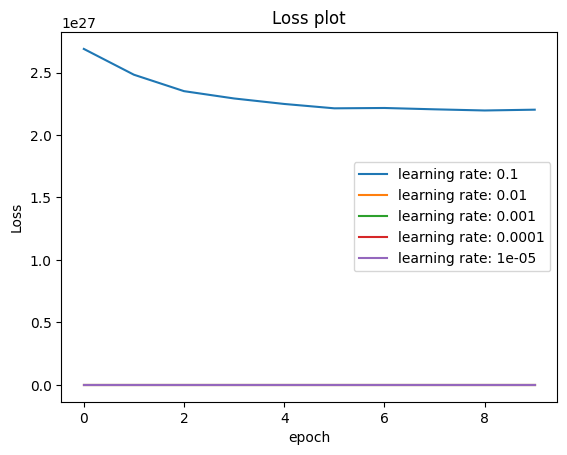

In [ ]:
####### plot the the training loss here #########

epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_loss_hyper_paramaters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')

plt.legend()

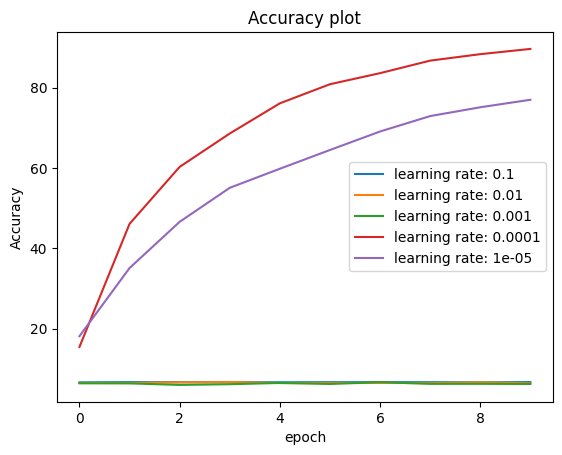

In [ ]:
####### plot the the training accuracies here #########

epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_acc_hyper_paramaters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')

plt.legend()